# Проект: классификация

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [63]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [64]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [66]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [67]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [68]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance']=df['balance'].apply(lambda x: 0 if x == '0  $ ' else float(str(x).split(',')[0].replace(' ', '')))
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [69]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance']=df['balance'].fillna(df['balance'].median())
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [70]:
df['education'].mode().to_frame()['education'].iloc[0]

'secondary'

In [71]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job']=df['job'].apply(lambda x: df['job'].mode().to_frame()['job'].iloc[0] if x == 'unknown' else x)
df['education']=df['education'].apply(lambda x: df['education'].mode().to_frame()['education'].iloc[0] if x == 'unknown' else x)
print(round(df[(df['education']==df['education'].mode().to_frame()['education'].iloc[0]) & (df['job']==df['job'].mode().to_frame()['job'].iloc[0])]['balance'].mean(), 3))

1598.883


### Задание 6

In [72]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, df_cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_cleaned.shape[0]}')
print(round(lower_bound))
print(round(upper_bound))

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
-2241
4063


## Часть 2:  Разведывательный анализ

### Задание 1

Sessions without purchase : 4681


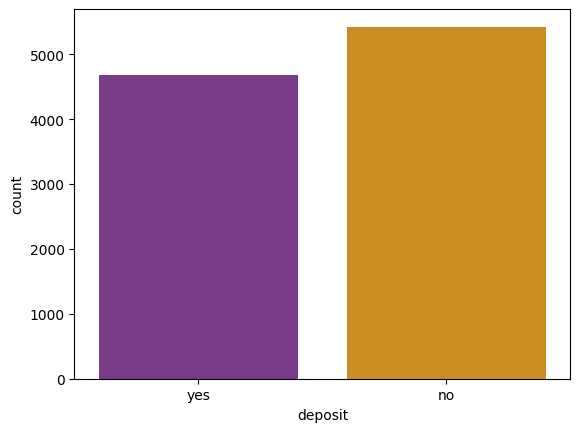

In [73]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
sns.countplot(x='deposit', data=df_cleaned, palette='CMRmap')
class_percent = df_cleaned['deposit'].value_counts()
print('Sessions without purchase : {}'.format(class_percent.loc['yes']))

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


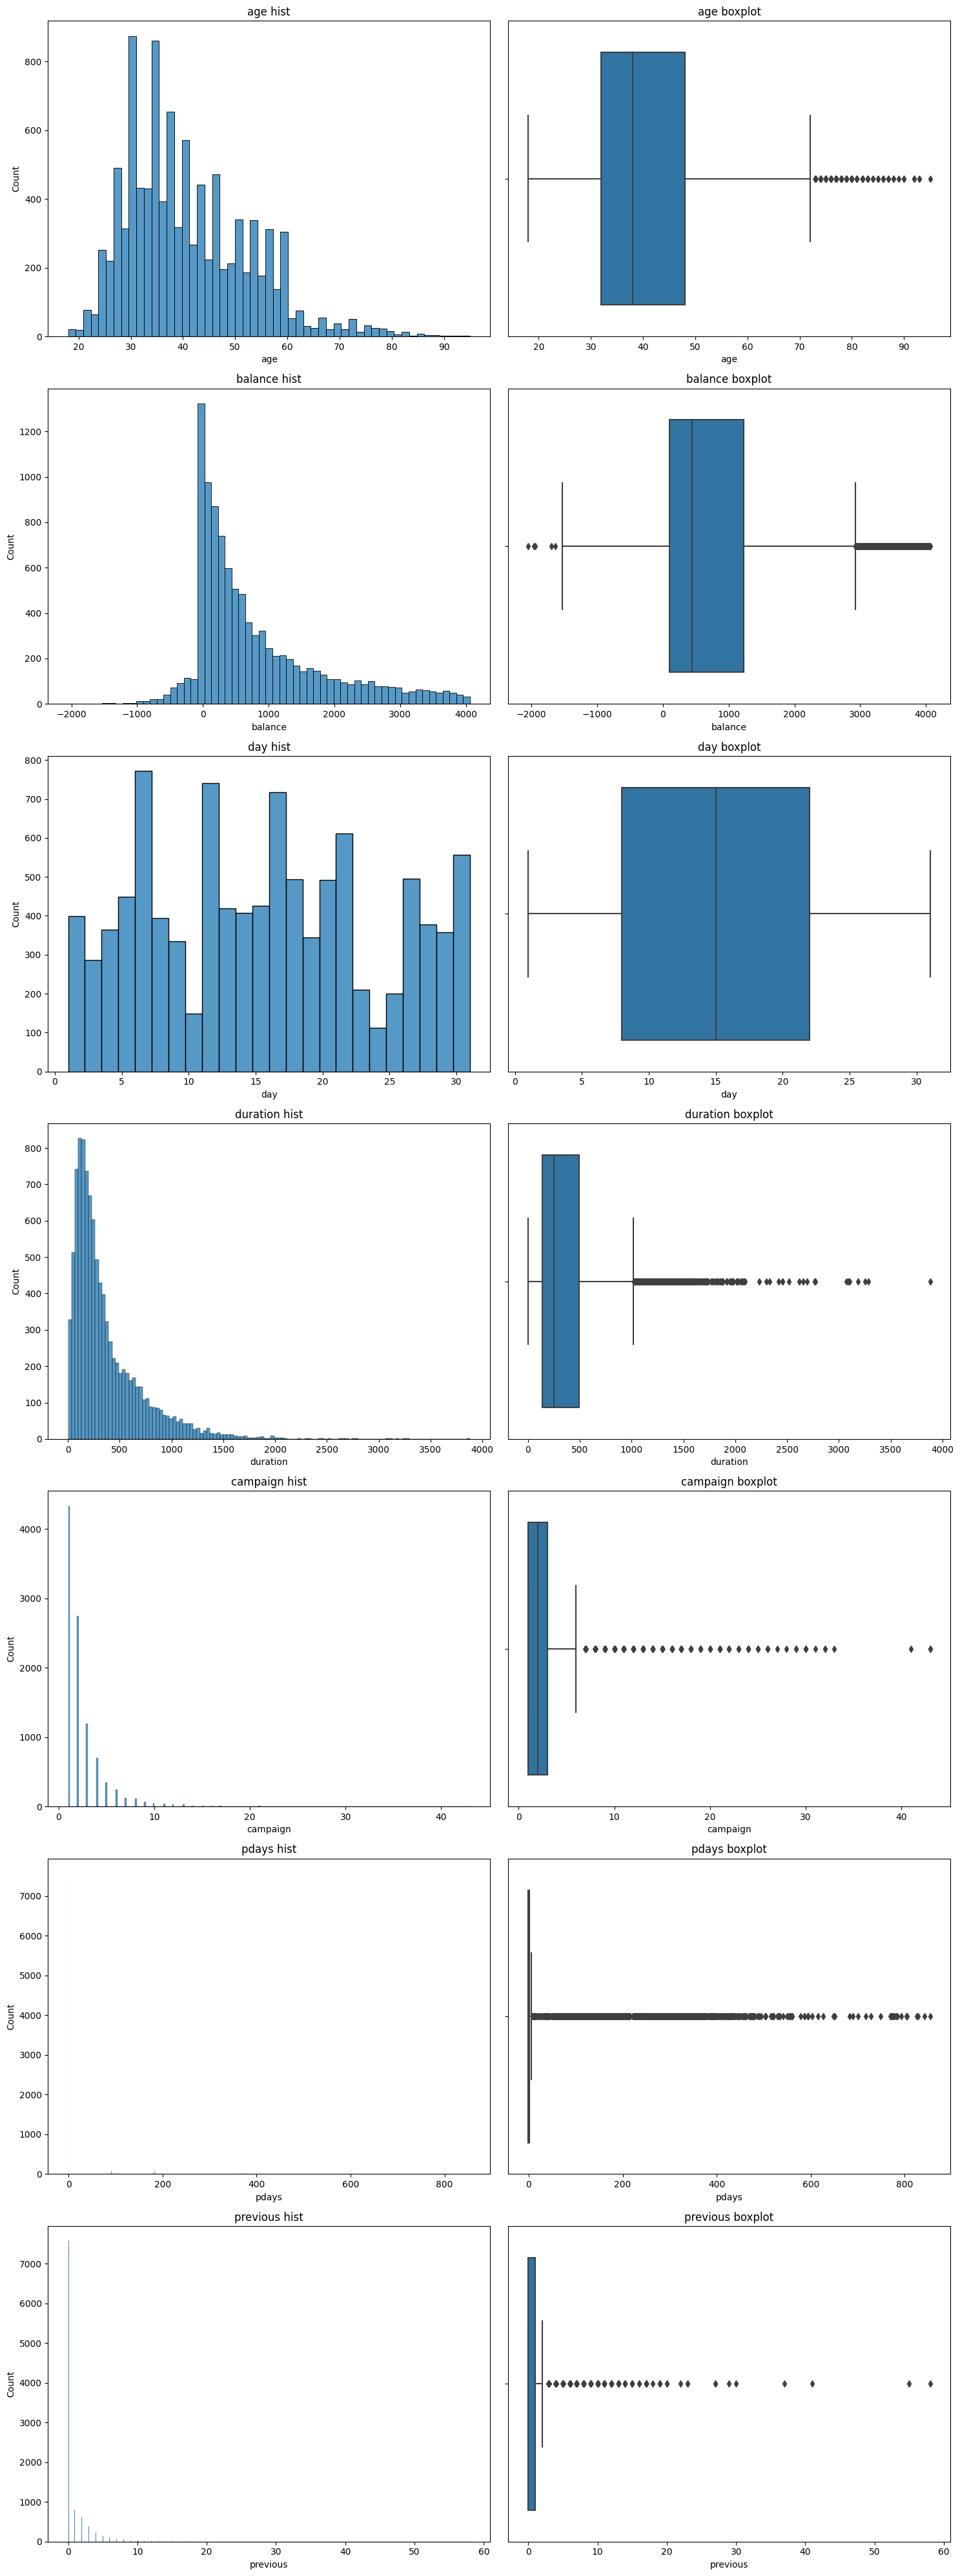

In [74]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код


types = df_cleaned.dtypes
num_features = list(types[(types != 'object')].index)

n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=df_cleaned, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим диаграмму рассеяния + линейную регрессию
    box_plot = sns.boxplot(data=df_cleaned, x=feature, ax=axes[i][1])
    #Добавляем подпись графику
    box_plot.set_title('{} boxplot'.format(feature));
plt.tight_layout()

df_cleaned.describe()

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


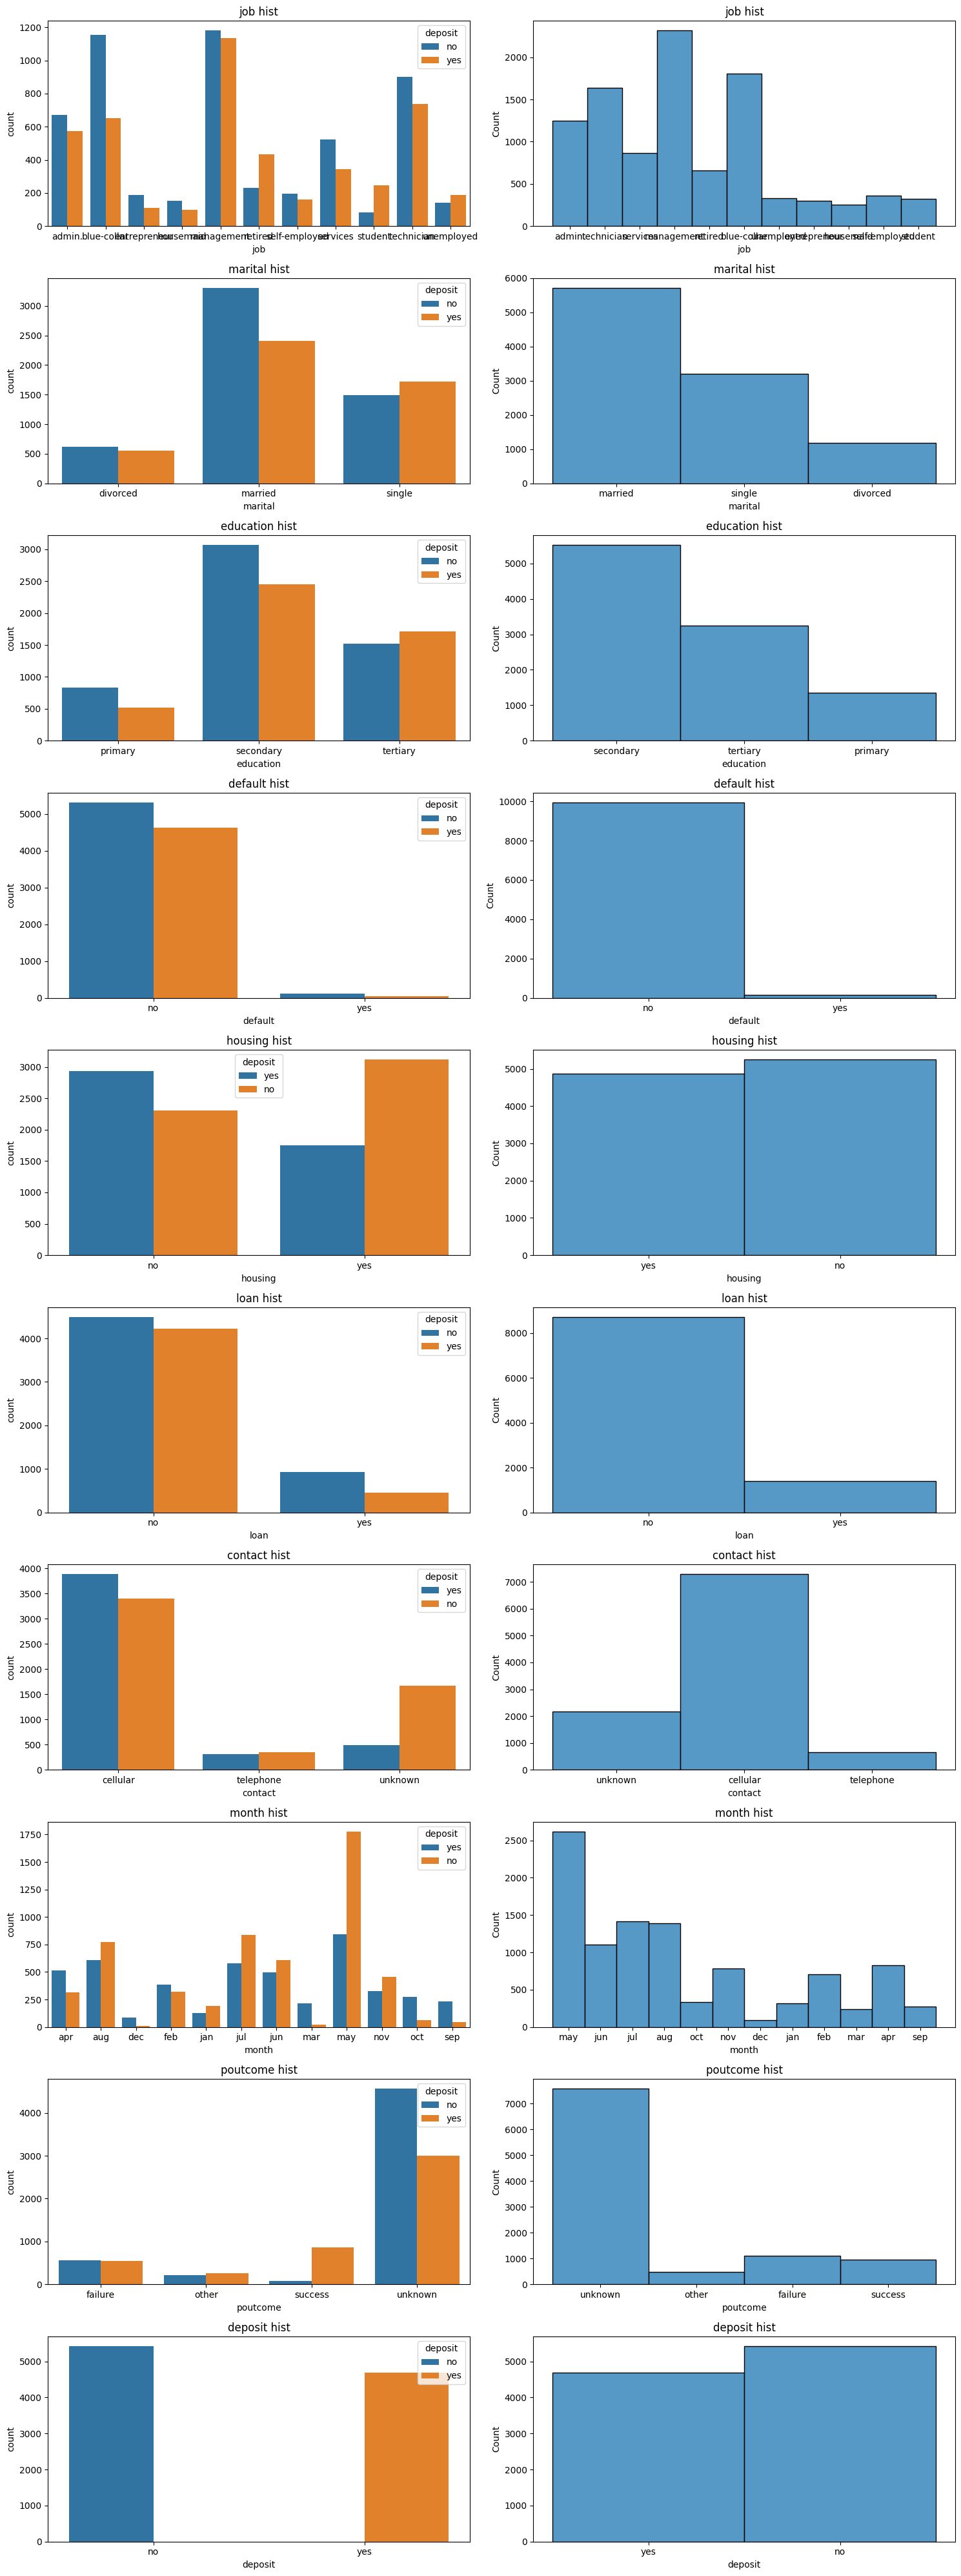

In [75]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

obj_features = list(types[(types == 'object')].index)

n = len(obj_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(obj_features): #i- индекс, feature - название признака в таблице
    #Создаем выборку, сгруппированную по признаку депозита
    bar_data= df_cleaned.groupby(
    by=feature,
    as_index=False
    )['deposit'].value_counts()
    #Строим столбчатую диагарамму 
    barplot = sns.barplot(data=bar_data, x=feature, y='count', hue='deposit', ax=axes[i][0])
    #Добавляем подпись графику
    barplot.set_title('{} hist'.format(feature))
    #Строим гистограмму распределения признака
    histplot = sns.histplot(data=df_cleaned, x=feature, ax=axes[i][1])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature));
plt.tight_layout()

df_cleaned.describe(include='object')

### Задание 6

In [76]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_cleaned[['poutcome', 'deposit']].value_counts().sort_index()

poutcome  deposit
failure   no          562
          yes         547
other     no          216
          yes         265
success   no           84
          yes         861
unknown   no         4562
          yes        3008
Name: count, dtype: int64

### Задание 7

In [77]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df_cleaned[['month', 'deposit']].value_counts().sort_index()

month  deposit
apr    no          317
       yes         513
aug    no          775
       yes         610
dec    no            9
       yes          84
feb    no          323
       yes         386
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    no           24
       yes         213
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    no           62
       yes         273
sep    no           46
       yes         232
Name: count, dtype: int64

### Задание 8

In [78]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_group(x):
    if x < 30:
        return '<30'
    elif 30<= x <40:
        return '30-40'
    elif 40<= x <50:
        return '40-50'
    elif 50<= x <60:
        return '50-60'
    else:
        return '60+'
        
df_cleaned['age_groups']=df_cleaned['age'].apply(get_age_group)

import plotly
import plotly.express as px

bar_data= df_cleaned.groupby(
    by='age_groups',
    as_index=False
)['deposit'].value_counts()

fig = px.bar(
    data_frame=bar_data,
    x="age_groups", 
    y="count", 
    color="deposit",
    labels={'deposit':'Открыт ли депозит', 'count':'количество клиентов, чел.', 'age_groups':'Возрастная группа клиентов'},
    barmode="group",
    orientation='v',
    title='Открытие депозита по возрастным группам'
);

fig.show()


### Задания 9 и 10

In [79]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
bar_data= df_cleaned.groupby(
    by='marital',
    as_index=False
)['deposit'].value_counts()

fig = px.bar(
    data_frame=bar_data,
    x="marital", 
    y="count", 
    color="deposit",
    labels={'deposit':'Открыт ли депозит', 'count':'количество клиентов, чел.', 'marital':'Семейное положение'},
    barmode="group",
    orientation='v',
    title='Открытие депозита по семейному положению'
);

fig.show()

In [80]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
bar_data= df_cleaned.groupby(
    by='education',
    as_index=False
)['deposit'].value_counts()

fig = px.bar(
    data_frame=bar_data,
    x="education", 
    y="count", 
    color="deposit",
    labels={'deposit':'Открыт ли депозит', 'count':'количество клиентов, чел.', 'education':'Уровень образования'},
    barmode="group",
    orientation='v',
    title='Открытие депозита по уровню образования'
);

fig.show()

In [81]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
bar_data= df_cleaned.groupby(
    by='job',
    as_index=False
)['deposit'].value_counts()

fig = px.bar(
    data_frame=bar_data,
    x="job", 
    y="count", 
    color="deposit",
    labels={'deposit':'Открыт ли депозит', 'count':'количество клиентов, чел.', 'job':'Профессиональная деятельность'},
    barmode="group",
    orientation='v',
    title='Открытие депозита по профессиональной деятельности'
);

fig.show()

### Задание 11

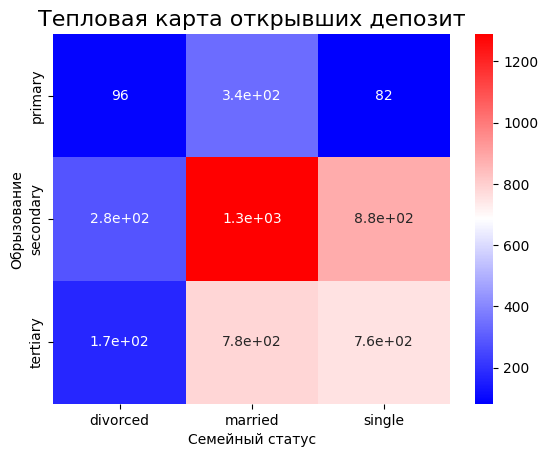

In [82]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_depo_yes=df_cleaned[df_cleaned['deposit']=='yes']


pivot_yes = df_depo_yes.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'   
)

heatmap = sns.heatmap(data=pivot_yes, cmap='bwr', annot=True)
heatmap.set_title('Тепловая карта открывших депозит', fontsize=16);
heatmap.set_xlabel('Семейный статус');
heatmap.set_ylabel('Обрызование');




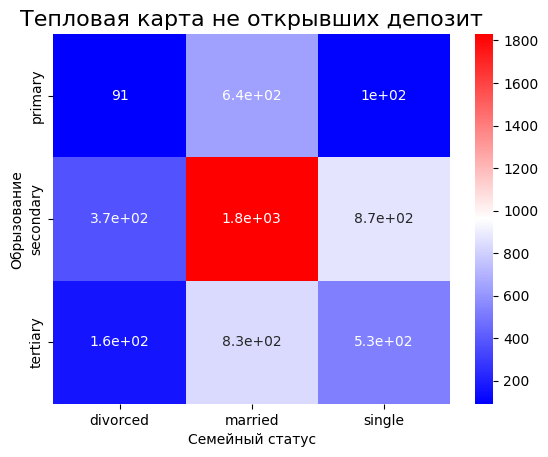

In [83]:
df_depo_no=df_cleaned[df_cleaned['deposit']=='no']

pivot_no = df_depo_no.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'   
)

heatmap = sns.heatmap(data=pivot_no, cmap='bwr', annot=True)
heatmap.set_title('Тепловая карта не открывших депозит', fontsize=16);
heatmap.set_xlabel('Семейный статус');
heatmap.set_ylabel('Обрызование');

## Часть 3: преобразование данных

### Задание 1

In [84]:
# преобразуйте уровни образования
le=LabelEncoder()
le.fit(df_cleaned['education'])
df_cleaned['education']=le.transform(df_cleaned['education'])
df_cleaned['education'].sum()

11995

In [85]:
le=LabelEncoder()
le.fit(df_cleaned['age_groups'])
df_cleaned['age_groups']=le.transform(df_cleaned['age_groups'])

### Задания 2 и 3

In [86]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_cleaned['deposit']=df_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['default']=df_cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['housing']=df_cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['loan']=df_cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)

print(round(df_cleaned['default'].mean()+df_cleaned['housing'].mean()+df_cleaned['loan'].mean(), 3))

0.635


### Задание 4

In [87]:
df.shape

(11162, 17)

In [88]:
df_cleaned.describe(include='object')

,job,marital,contact,month,poutcome
count,10105,10105,10105,10105,10105
unique,11,3,3,12,4
top,management,married,cellular,may,unknown
freq,2315,5715,7283,2617,7570


In [89]:
# создайте дамми-переменные
df_dummies = pd.get_dummies(df_cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_groups         10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

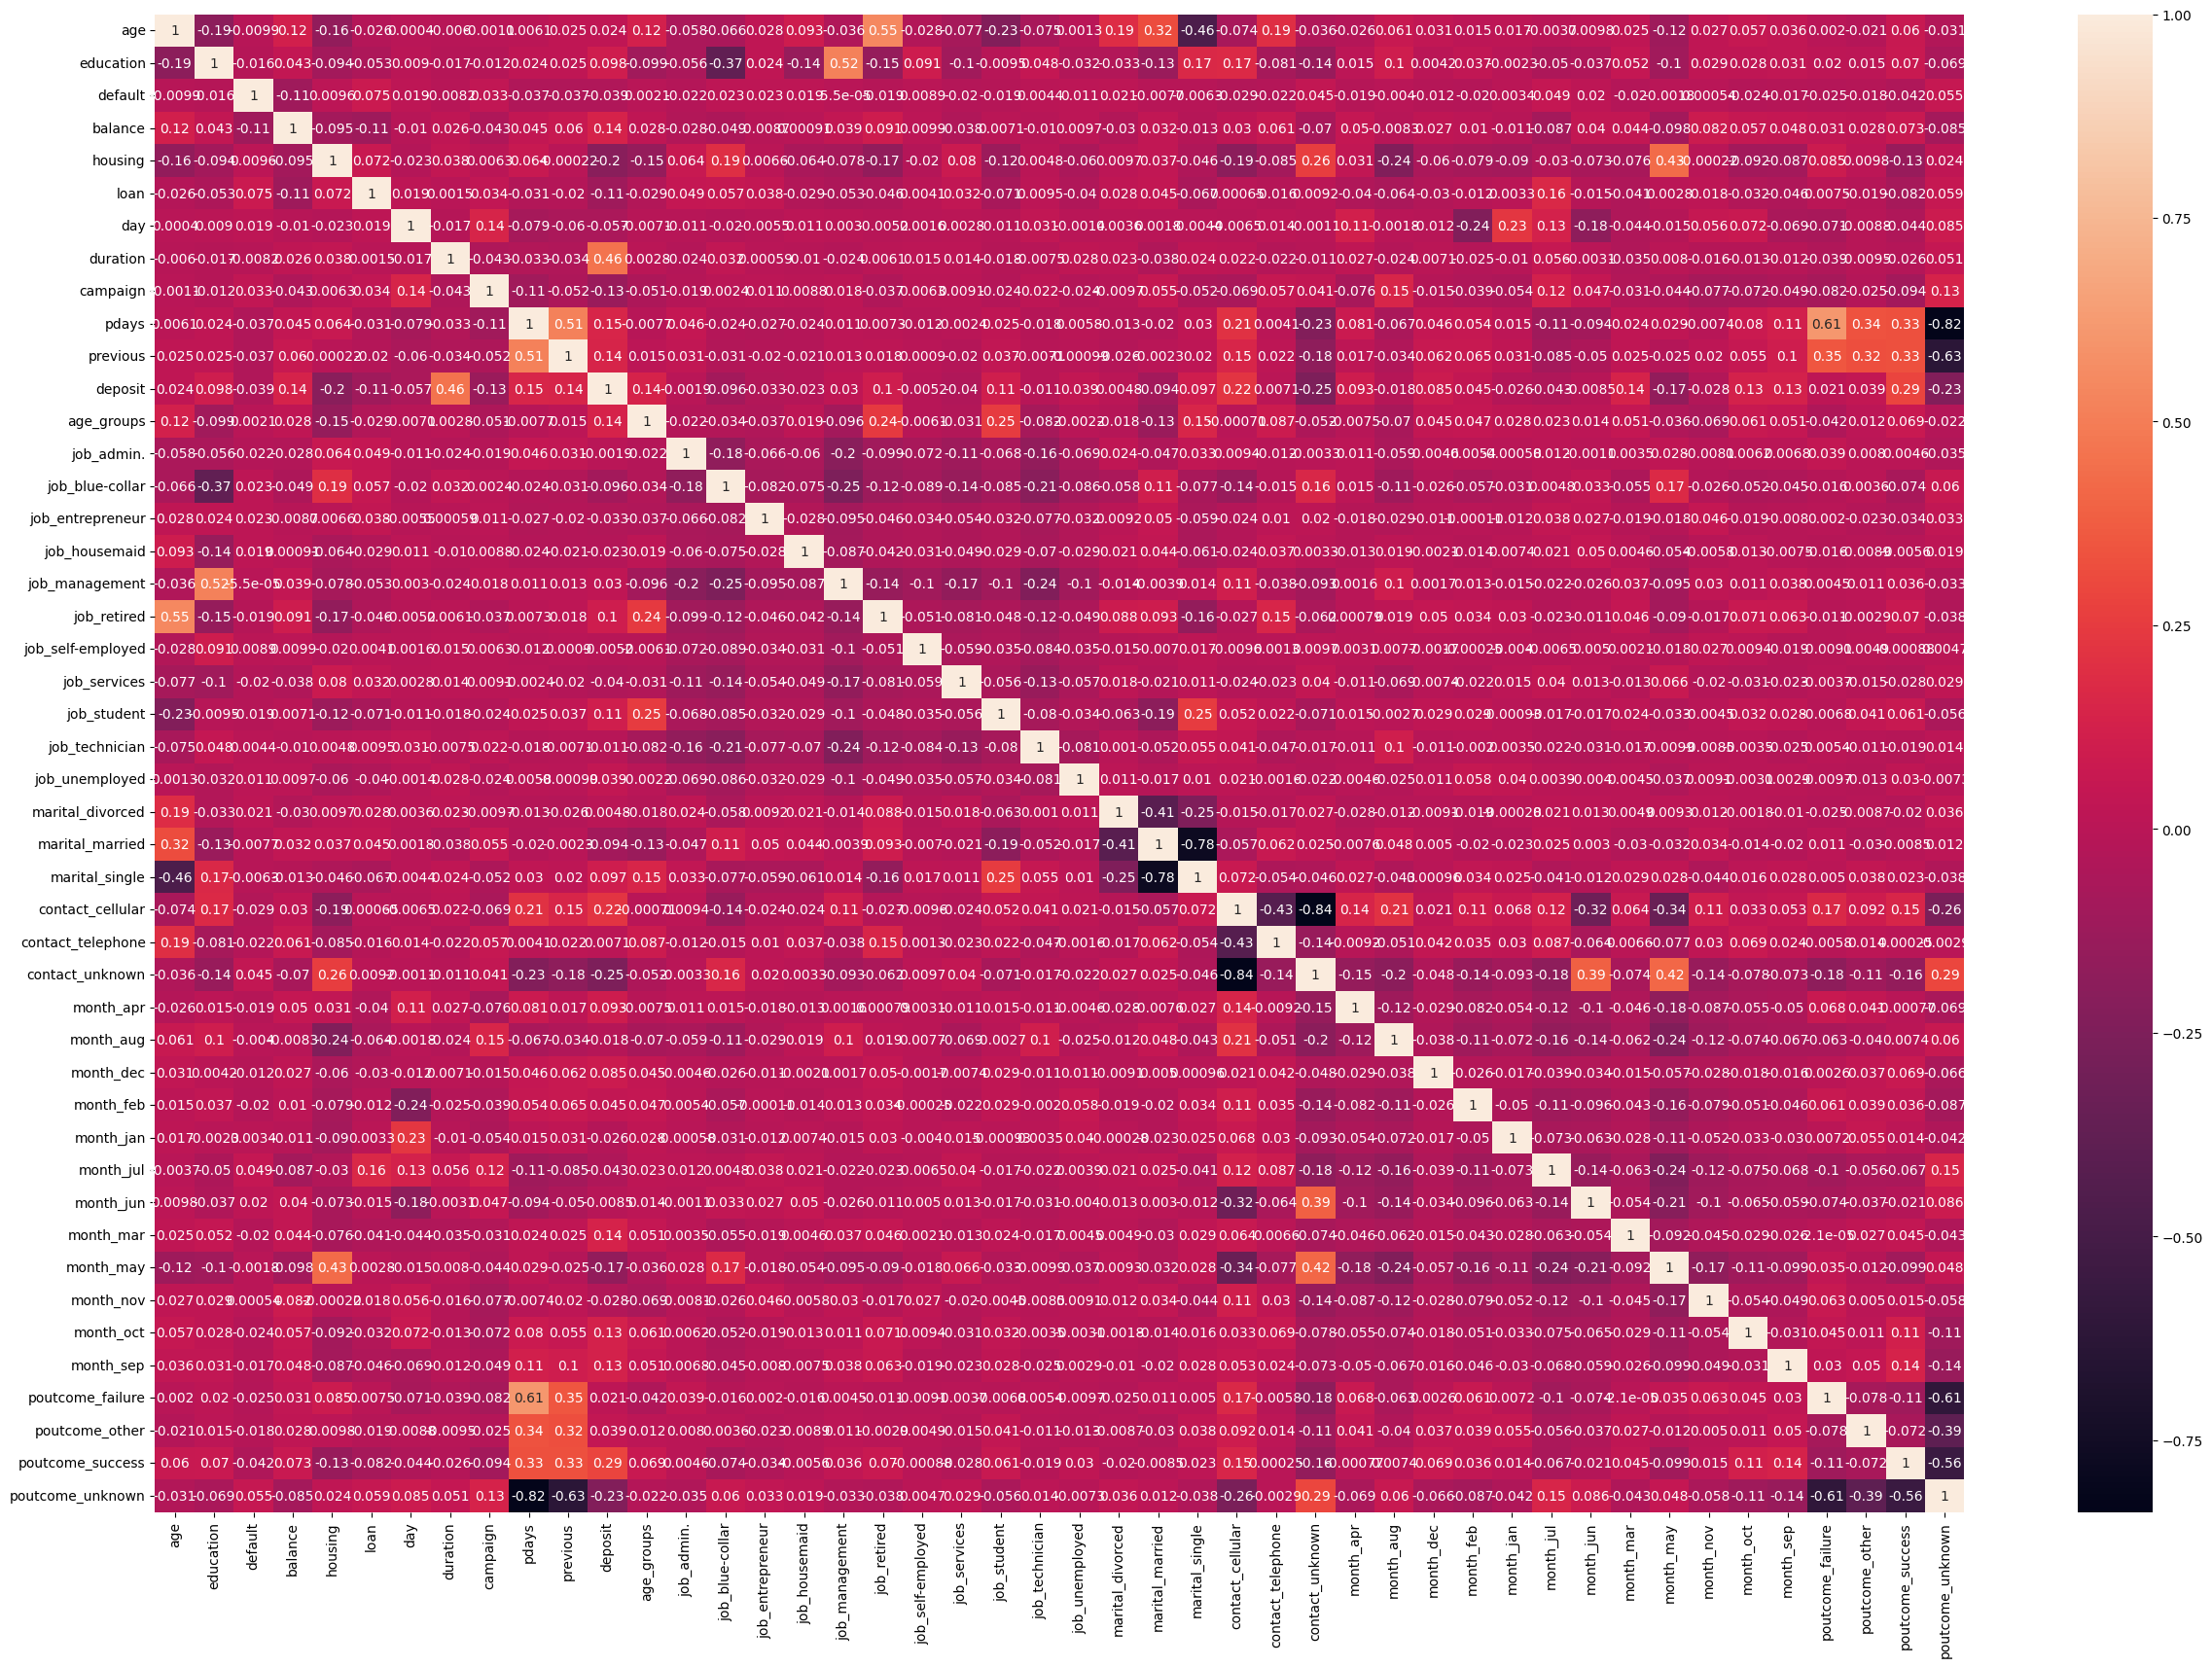

In [90]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30,20))
ax=sns.heatmap(df_dummies.corr(), annot=True)
plt.show()

### Задания 7 и 8

In [91]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [92]:
# рассчитайте необходимые показатели
y.mean()

0.4632360217714003

### Задание 9

In [93]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector = selector.fit(X_train, y_train)
 
columns = selector.get_feature_names_out()

X_train = X_train[columns]
X_test = X_test[columns]


### Задание 10

In [94]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns)

X_test_scaled['balance'].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [95]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_clf = linear_model.LogisticRegression(max_iter=1000, random_state=42, solver='sag')

log_clf.fit(X_train_scaled, y_train)

y_train_pred= log_clf.predict(X_train_scaled)
y_test_pred= log_clf.predict(X_test_scaled)

print(f'Качество предсказания по accuracy для логистической регрессии на обучающей выборке {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(metrics.classification_report(y_train, y_train_pred))
print(f'Качество предсказания по accuracy для логистической регрессии на тестовой выборке {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')
print(metrics.classification_report(y_test, y_test_pred))

Качество предсказания по accuracy для логистической регрессии на обучающей выборке 0.82
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Качество предсказания по accuracy для логистической регрессии на тестовой выборке 0.8
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [96]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)

dt_clf.fit(X_train_scaled, y_train)

y_train_pred = dt_clf.predict(X_train_scaled)
y_test_pred = dt_clf.predict(X_test_scaled)

print(f'Качество предсказания по accuracy для дерева решений на обучающей выборке {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(metrics.classification_report(y_train, y_train_pred))
print(f'Качество предсказания по accuracy для дерева решений на тестовой выборке {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')
print(metrics.classification_report(y_test, y_test_pred))

Качество предсказания по accuracy для дерева решений на обучающей выборке 0.82
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Качество предсказания по accuracy для дерева решений на тестовой выборке 0.81
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [97]:
from sklearn.model_selection import GridSearchCV

# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search_tree.fit(X_train_scaled, y_train)
y_train_pred = grid_search_tree.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.2f}".format(grid_search_tree.score(X_train_scaled, y_train)))
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = grid_search_tree.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
print("f1-score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

accuracy на обучающем наборе: 0.84
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.81      0.84      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.83      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

accuracy на тестовом наборе: 0.82
f1-score на тестовом наборе: 0.81
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [98]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf_clf.fit(X_train_scaled, y_train)

y_train_pred = rf_clf.predict(X_train_scaled)
y_test_pred = rf_clf.predict(X_test_scaled)

print(f'Качество предсказания по accuracy для случайного леса на обучающей выборке {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(metrics.classification_report(y_train, y_train_pred))
print(f'Качество предсказания по accuracy для случайного леса на тестовой выборке {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')
print(metrics.classification_report(y_test, y_test_pred))

Качество предсказания по accuracy для случайного леса на обучающей выборке 0.86
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Качество предсказания по accuracy для случайного леса на тестовой выборке 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [99]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    min_samples_leaf=5,
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

print(f'Качество предсказания по accuracy для градиентного бустинга на обучающей выборке {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(metrics.classification_report(y_train, y_train_pred))
print(f'Качество предсказания по accuracy для градиентного бустинга на тестовой выборке {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')
print(metrics.classification_report(y_test, y_test_pred))



Качество предсказания по accuracy для градиентного бустинга на обучающей выборке 0.89
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Качество предсказания по accuracy для градиентного бустинга на тестовой выборке 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [100]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(max_iter=1000, random_state=42, solver='sag')),
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( #метамодель                    
        max_iter=1000,
        solver='sag',
        random_state=42 #датчик генератора случайных чисел
    )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

y_train_pred= reg.predict(X_train_scaled)
y_test_pred= reg.predict(X_test_scaled)

print(f'Качество предсказания по accuracy для стекинга на обучающей выборке {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(metrics.classification_report(y_train, y_train_pred))
print(f'Качество предсказания по accuracy для стекинга на тестовой выборке {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')
print(metrics.classification_report(y_test, y_test_pred))

Качество предсказания по accuracy для стекинга на обучающей выборке 0.87
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Качество предсказания по accuracy для стекинга на тестовой выборке 0.82
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [101]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE

estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [103]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

[I 2024-11-20 11:07:02,418] A new study created in memory with name: RandomForestClassifier
[I 2024-11-20 11:07:02,861] Trial 0 finished with value: 0.8417741428122051 and parameters: {'n_estimators': 147, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8417741428122051.
[I 2024-11-20 11:07:03,151] Trial 1 finished with value: 0.8451104100946373 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8451104100946373.
[I 2024-11-20 11:07:03,563] Trial 2 finished with value: 0.8561590233213335 and parameters: {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8561590233213335.
[I 2024-11-20 11:07:04,108] Trial 3 finished with value: 0.8511372549019608 and parameters: {'n_estimators': 185, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8561590233213335.
[I 2024-11-20 11:07:04,543] Trial 4 finished with value: 0.8502900141087945 and parameters: {'

Наилучшие значения гиперпараметров {'n_estimators': 102, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

